# Calculate phase from center of mass

In [1]:
%matplotlib inline

from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
import numpy as np
import imageio

import ncempy.io as nio

import ipywidgets as widgets
from ipywidgets import interact, interactive

import stempy.io as stio
import stempy.image as stim

distiller_path = Path('/global/cfs/projectdirs/ncemhub/distiller/')

In [2]:
# Load a sparse 4D camera data set

# Close all previous windows to avoid too many windows
plt.close('all')

date = '2022.03.01'
scan_num = 12
threshold = 4.5
scan_id = 1423

dPath = distiller_path / Path('counted') / Path(date)
fPath = Path('data_scan{}_id{}_th{}_electrons.h5'.format(scan_num, scan_id, threshold))
fname = dPath / fPath
haadf_path = distiller_path / Path('dm4') / Path(date) / Path(f'scan{scan_num}.dm4')

# Local testing
scan_num = 186
scan_id = 1842
fname = Path(f'/mnt/nvme1/percius/stempy_tests_temp/data_scan{scan_num}_id{scan_id}_electrons.h5')

# Load the HAADF
if haadf_path.exists():
    haadf = nio.dm.dmReader(haadf_path)
    fg, ax = plt.subplots(1, 1)
    ax.imshow(haadf['data'])
    ax.set(title='Simultaneously acquire HAADF')
else:
    print('No HAADF available')

sp = stio.SparseArray.from_hdf5(fname)
print(sp.shape)
sp = sp[:,:-1,:,:] # remove the fly back column

# Calculate number of electrons per pattern
num_elec = 0
for frames in sp.data:
    for frame in frames:
        num_elec += len(frame)
avg_elec = num_elec / (sp.num_scans * sp.num_frames_per_scan)

print('File: {}'.format(fname))
print('Scan dimensions = {}'.format(sp.scan_shape))
print('Mean electrons per pattern: {}'.format(avg_elec))
if haadf_path.exists():
    print('Dose (on camera) = {} per {}^2'.format(avg_elec/haadf['pixelSize'][0]**2, haadf['pixelUnit'][0]))

No HAADF available
(256, 257, 576, 576)
File: /mnt/nvme1/percius/stempy_tests_temp/data_scan186_id1842_electrons.h5
Scan dimensions = (256, 256)
Mean electrons per pattern: 871.4141540527344


[[298.46356062]
 [297.94996743]]
Showing power law normalized intensities


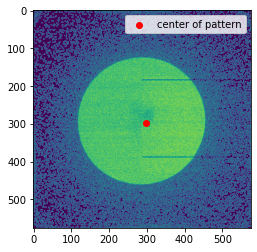

In [11]:
# Calculate a summed diffraction pattern of frames
# And find the center

dp = sp[::10, ::10, :, :].sum(axis=(0,1)) 
#stim.calculate_sum_sparse(sp.data[::10], sp.frame_shape) # old...does not work with multi-frame

# Set the center of the pattern (use figure below for manual)
_ = dp.copy()
_[_ < 5] = 0
center = stim.com_dense(_)
# center = (270, 295)
print(center)

print('Showing power law normalized intensities')
fg,ax = plt.subplots(1, 1)
# ax.imshow(dp, norm=LogNorm())
ax.imshow(dp, norm=PowerNorm(0.25))
ax.scatter(center[0], center[1], c='r')
ax.legend(['center of pattern']);

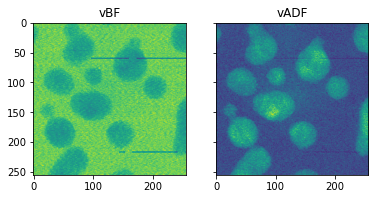

In [4]:
# Calculate a virtual bright field and dark field
inner_angles = (0, 180) # in pixels
outer_angles = (161, 288)

ims = stim.create_stem_images(sp, inner_angles, outer_angles, center=center) # here center is (col, row)
bf = ims[0,]
adf = ims[1,]

fg,ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].imshow(bf,vmin=bf[10:-10,10:-10].min(),vmax=bf[10:-10,10:-10].max())
ax[0].set(title='vBF')
ax[1].imshow(adf,vmin=adf[10:-10,10:-10].min(),vmax=adf[10:-10,10:-10].max())
ax[1].set(title='vADF');

Crop to: (50, 50) pixels


[Text(0.5, 1.0, 'scan 186')]

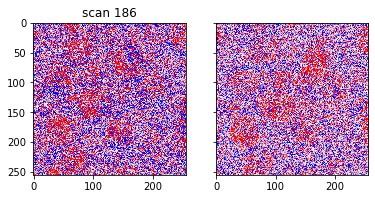

In [5]:
# Calculate the center of mass (COM) of every frame
crop_to = (50, 50) # non-square untested
print('Crop to: {} pixels'.format(crop_to))

com = stim.com_sparse(sp, crop_to=crop_to)

# Find the stats for plotting
com_mean = np.mean(com, axis=(1, 2))
com_std = np.std(com,axis=(1, 2))

fg,ax = plt.subplots(1,2,sharex=True,sharey=True)
axim0 = ax[0].imshow(com[0,], cmap='bwr', vmin=com_mean[0]-com_std[0], vmax=com_mean[0]+com_std[0],interpolation='none')
axim1 = ax[1].imshow(com[1,], cmap='bwr', vmin=com_mean[1]-com_std[1], vmax=com_mean[1]+com_std[1],interpolation='none')
ax[0].set(title='scan {}'.format(scan_num))


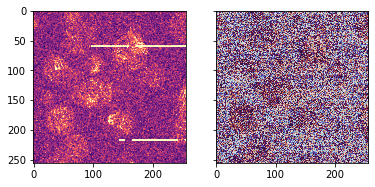

In [6]:
# Calculate the radius and angle for each COM measurement
com_r = np.sqrt( (com[0,] - com_mean[0])**2 + (com[1,] - com_mean[1])**2 )
com_theta = np.arctan2((com[1,] - com_mean[1]), (com[0,] - com_mean[0]))

fg,ax = plt.subplots(1, 2, sharex=True, sharey=True)
ax[0].imshow(com_r / np.std(com_r), cmap='magma', vmax=3)
ax[1].imshow(com_theta, cmap='twilight', interpolation='none')

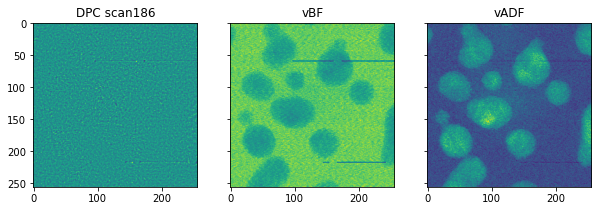

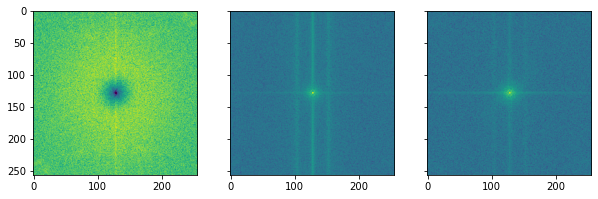

In [7]:
# Retrieve phase from center of mass
# 200 and 300 kV are -9 if Gatan + TIA = 0. If TIA = -14 (for TS movement) then the theta should be -23
flip = True
theta = -9 * np.pi / 180. # rotation between diffraction and real space scan directions
reg = 11e-2

# Calculate the phase
ph = stim.phase_from_com(com, flip=flip, theta=theta, reg=reg)

fg,ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,5))
ax[0].imshow(ph,vmin=ph[10:-10,].min(),vmax=ph[10:-10,].max())
ax[0].set(title='DPC scan{}'.format(scan_num))
ax[1].imshow(bf)
ax[1].set(title='vBF')
ax[2].imshow(adf)
ax[2].set(title = 'vADF')
# fg.tight_layout()

fg,ax = plt.subplots(1,3,sharex=True,sharey=True, figsize=(10,5))
ax[0].imshow(np.abs(np.fft.fftshift(np.fft.fft2(ph))),norm=LogNorm(vmin=1))
ax[1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(bf))),norm=LogNorm())
ax[2].imshow(np.abs(np.fft.fftshift(np.fft.fft2(adf))),norm=LogNorm())
# fg.tight_layout()

In [8]:
# Save the data
print('Saving COM and DPC for scan number {}'.format(scan_num))
imageio.imwrite(fname.with_name('scan{}_DPC'.format(scan_num)).with_suffix('.tif'), ph.astype(np.float32))
imageio.imwrite(fname.with_name('scan{}_comx'.format(scan_num)).with_suffix('.tif'), com[0,].astype(np.float32))
imageio.imwrite(fname.with_name('scan{}_comy'.format(scan_num)).with_suffix('.tif'), com[1,].astype(np.float32))
imageio.imwrite(fname.with_name('scan{}_BF'.format(scan_num)).with_suffix('.tif'), bf.astype(np.float32))
imageio.imwrite(fname.with_name('scan{}_ADF'.format(scan_num)).with_suffix('.tif'), adf.astype(np.float32))
print(fname.with_name('scan{}_DPC'.format(scan_num)).with_suffix('.tif'))

Saving COM and DPC for scan number 186
/mnt/nvme1/percius/stempy_tests_temp/scan186_DPC.tif


interactive(children=(FloatSlider(value=0.1, description='reg:', max=0.1, min=1e-06, readout_format='f', step=…

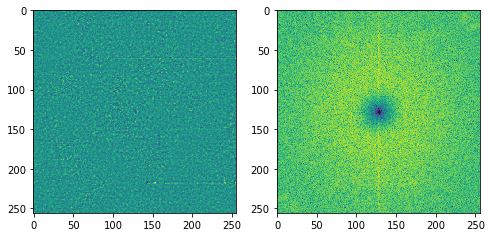

In [9]:
# OPTIONAL: Interactive plot to find ideal regularization 

# Create interactive plot for DPC and DPC_fft plots
fg1, ax1 = plt.subplots(1,2,figsize=(8, 5))
im1ax1 = ax1[0].imshow(ph, interpolation='none') # Set the initial image and intenstiy scaling
im2ax1 = ax1[1].imshow(np.abs(np.fft.fftshift(np.fft.fft2(ph))),norm=LogNorm(vmin=1),interpolation='none')

def axUpdate(i):
    '''updates the plot'''
    _ = stim.phase_from_com(com, flip=flip, theta=theta, reg=i)[10:-10,10:-10]
    im1ax1.set_data(_)
    im1ax1.set_clim(_.min(), _.max())
    __ = np.abs(np.fft.fftshift(np.fft.fft2(_)))
    im2ax1.set_data(__)
    
w1 = widgets.FloatSlider(
    value=reg,
    min=1e-6,
    max=1e-1,
    step=1e-3,
    description='reg:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='f',
)

interactive(axUpdate, i=w1)